# Using PyBERT as a Library

This Jupyter notebook provides an example of using the functionality of the _PyBERT_ Python package, not as a stand alone GUI application, but rather as a library, importing into a higher level Python script.

Original author: David Banas <capn.freako@gmail.com>  
Original date:   June 28, 2021

Copyright &copy; 2021 David Banas, Inc.; all rights reserved World wide.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Global-Defines" data-toc-modified-id="Global-Defines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global Defines</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#PyBERT-Object" data-toc-modified-id="PyBERT-Object-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PyBERT Object</a></span></li><li><span><a href="#Tx-Output" data-toc-modified-id="Tx-Output-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tx Output</a></span></li><li><span><a href="#Channel-Model" data-toc-modified-id="Channel-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Channel Model</a></span></li><li><span><a href="#Rx-Equalization-and-Clock/Data-Recovery" data-toc-modified-id="Rx-Equalization-and-Clock/Data-Recovery-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Rx Equalization and Clock/Data Recovery</a></span></li></ul></div>

## Introduction

In the typical use case, [PyBERT](https://github.com/capn-freako/PyBERT/wiki) is run as a stand alone GUI application.
However, it is also possible to draw from the _PyBERT_ package, as a _library_, importing only certain needed features into a larger _Python_ script.
This [Jupyter](https://jupyter.org/) notebook provides an example of doing just that.

Furthermore, this example shows how to import _PyBERT_ functionality into a higher level _Python_ script, when [IBIS-AMI models](https://www.eetimes.com/ami-models-what-why-and-how/#) are being used, in place of PyBERT's native Tx/Rx models.

## Global Defines

If you get lucky, you might get away w/ only editing this section.

In [1]:
TX_IBIS_FILE = "../../ibisami/example/example_tx.ibs"
RX_IBIS_FILE = "../../ibisami/example/example_rx.ibs"


## Imports

Here, we import everything we'll need.
(I'm not sure why, but these notebooks tend to work more smoothly if you import everything first, before executing any other Python code.)


In [2]:
%matplotlib inline

import sys
import pprint

print(f"Python executable: {sys.executable}")
print(f"Python exec_prefix: {sys.exec_prefix}")
print(f"Python prefix: {sys.prefix}")
print("Python import search path:")
pprint.pp(sys.path)

import matplotlib.pyplot as plt
import numpy             as np
import scipy.signal      as sig

import pybert            as pb
import pyibisami         as pyami

from pybert.pybert       import PyBERT
from pybert.pybert_cntrl import my_run_simulation
from pybert.pybert_util  import calc_eye

from pyibisami.ami_model import AMIModel, AMIModelInitializer

print(f"PyBERT at: {pb.__file__}")
print(f"\tversion: {pb.__version__}")

print(f"PyAMI at: {pyami.__file__}")
print(f"\tversion: {pyami.__version__}")

plt.rcParams['figure.figsize'] = [12, 8]

Python executable: /Users/dbanas/opt/anaconda3/envs/pybert-dev/bin/python
Python exec_prefix: /Users/dbanas/opt/anaconda3/envs/pybert-dev
Python prefix: /Users/dbanas/opt/anaconda3/envs/pybert-dev
Python import search path:
['/Users/dbanas/Documents/Projects/PyBERT/misc',
 '/Users/dbanas/Documents/Projects/tvm/python',
 '/Users/dbanas/Documents/Projects/tvm/topi/python',
 '/Users/dbanas/Documents/Projects/tvm/nnvm/python',
 '/Users/dbanas/Documents/Projects/tvm/vta/python',
 '/Users/dbanas/Documents/Projects/PyBERT/misc',
 '/Users/dbanas/opt/anaconda3/envs/pybert-dev/lib/python38.zip',
 '/Users/dbanas/opt/anaconda3/envs/pybert-dev/lib/python3.8',
 '/Users/dbanas/opt/anaconda3/envs/pybert-dev/lib/python3.8/lib-dynload',
 '',
 '/Users/dbanas/opt/anaconda3/envs/pybert-dev/lib/python3.8/site-packages',
 '/Users/dbanas/Documents/Projects/PyBERT',
 '/Users/dbanas/Documents/Projects/PyBERT/PyAMI',
 '/Users/dbanas/opt/anaconda3/envs/pybert-dev/lib/python3.8/site-packages/IPython/extensions',
 

## PyBERT Object

Here, we instantiate and configure our _PyBERT_ object and run a trial simulation of an "ideal" channel, to generate the Tx output.

**Note:** You may need to dismiss some GUI dialog alerts.

**Note:** If you changed the Tx/Rx IBIS file names, above, then you'll probably get an error like this, the first time you run this cell:

```
ValueError: Failed parameter tree search looking for: <ParamName>; available keys: dict_keys(['tx_tap_nm2', 'tx_tap_np1', 'tx_tap_units', 'tx_tap_nm1'])
```

Just swap in one of the listed available keys, in line 20, and you should be good to go.

**Note:** If you get the following error, having set `myPyBERT.tx_use_ts4` to `True`:

```
TypeError: 'NoneType' object is not subscriptable
```

then your chosen IBIS file doesn't provide on-die S-parameters;
set `myPyBERT.tx_use_ts4` to `False` and re-run this cell.


In [5]:
myPyBERT = PyBERT(run_simulation=False, gui=False)
myPyBERT.bit_rate     = 56     # (Gbps)
myPyBERT.l_ch         = 0.001  # (m) "ideal" channel

myPyBERT.tx_ibis_file = TX_IBIS_FILE
assert (myPyBERT.tx_ibis_valid)
assert (myPyBERT.tx_dll_file)
assert (myPyBERT.tx_ami_file)
assert (myPyBERT.tx_ami_valid)
assert (myPyBERT.tx_dll_valid)

myPyBERT.rx_ibis_file = RX_IBIS_FILE
assert (myPyBERT.rx_ibis_valid)
assert (myPyBERT.rx_dll_file)
assert (myPyBERT.rx_ami_file)
assert (myPyBERT.rx_ami_valid)
assert (myPyBERT.rx_dll_valid)

# myPyBERT._tx_cfg.configure_traits()  # Use the GUI configurator, for now.
myPyBERT._tx_cfg.set_param_val(["Model_Specific","tx_tap_nm1"], 3.0)  # Bypass the GUI config.
print(myPyBERT._tx_cfg.fetch_param_val(["Model_Specific","tx_tap_nm1"]))
myPyBERT.tx_use_ibis    = True
myPyBERT.tx_use_ami     = True
myPyBERT.tx_use_getwave = True
myPyBERT.tx_use_ts4     = False
my_run_simulation(myPyBERT, initial_run=True, update_plots=False)
print(myPyBERT.console_log)
# tx_model = myPyBERT.tx_model

ui   = myPyBERT.ui           # unit interval
nspb = myPyBERT.nspb         # samples per bit
t    = myPyBERT.t            # simulation time vector
Ts   = t[1]                  # simulation time interval
eye_bits = myPyBERT.eye_bits # number of UIs to use for eye plotting.


3.0
PyBERT Console Log


[2021-08-08 08:30:18.351424]: Started.

[2021-08-08 08:30:18.351460]: System: Darwin 18.7.0

[2021-08-08 08:30:18.351479]: Python Version: 3.8.5

[2021-08-08 08:30:18.351485]: PyBERT Version: 3.4.0

[2021-08-08 08:30:18.742726]: Parsing Tx IBIS file, '../../ibisami/example/example_tx.ibs'...

[2021-08-08 08:30:18.767322]: Result:
Success!

[2021-08-08 08:30:18.767826]: Parsing Tx AMI file, '../../ibisami/example/example_tx.ami'...

[2021-08-08 08:30:18.771745]: Success.

[2021-08-08 08:30:18.772073]: Parsing Rx IBIS file, '../../ibisami/example/example_rx.ibs'...

[2021-08-08 08:30:18.789650]: Result:
Success!

[2021-08-08 08:30:18.800768]: Parsing Rx AMI file, '../../ibisami/example/example_rx.ami'...

[2021-08-08 08:30:19.094639]: Channel impulse response is 626 samples long.

[2021-08-08 08:30:19.125402]: Tx IBIS-AMI model initialization results:
Input parameters: b'(example_tx (tx_tap_nm2 0)(tx_tap_np1 0)(tx_tap_units 27)(tx_tap_nm1 3.0))'
Output parameters

## Tx Output

Here, we plot the last 100 unit intervals, as well as the "eye" diagram, for the output of the Tx.

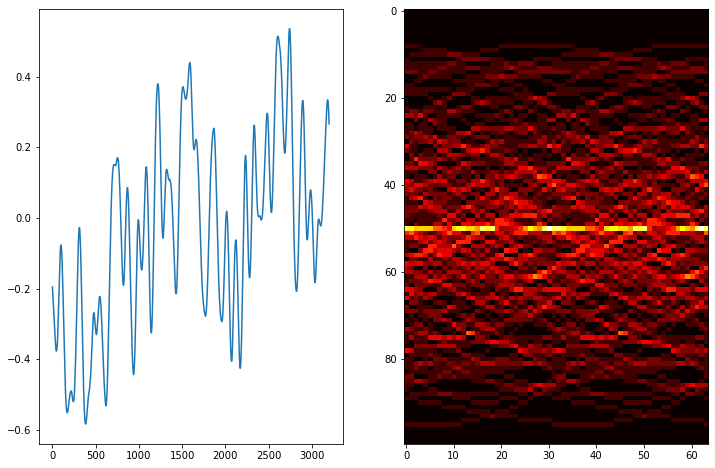

In [6]:
sig = myPyBERT.rx_in  # `tx_out` is the ideal "bit stream".

def plotsig(sig):
    """Plot last 100 unit intervals, as well as the 'eye' diagram, of a signal.
    """
    ys    = sig[-eye_bits*nspb:]
    y_max = np.max(ys) * 1.1
    img   = calc_eye(ui, nspb, 100, ys, y_max)
    plt.subplot(121)
    plt.plot(sig[-100*nspb:])
    plt.subplot(122)
    plt.hot()
    plt.imshow(img, aspect="auto")
    plt.show()

plotsig(sig)


## Channel Model

Here, we (optionally) apply a custom channel model to the signal above.

In [7]:
def channel_model(sig):
    """Custom channel model."""
    return(sig)  # REPLACE ME!

## Rx Equalization and Clock/Data Recovery

Here, we model the receiver equalization and clock/data recovery functionality.

Rx IBIS-AMI model initialization results:
Input parameters: b'(example_rx (ctle_mode 0)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 0.0)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))'
Message: b'Input parameter string: (example_rx (ctle_mode 0)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 0.0)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))\nDebugging parameters:\n\tenable: 0\n\tsig_tap: 0\n\tinit_adapt_tap: 0\nInitializing Rx...\nibisami example Rx model was configured successfully, as follows:\n\tCTLE: not present\n\tDFE: not present\n'
Output parameters: b'(example_rx\n)\n'


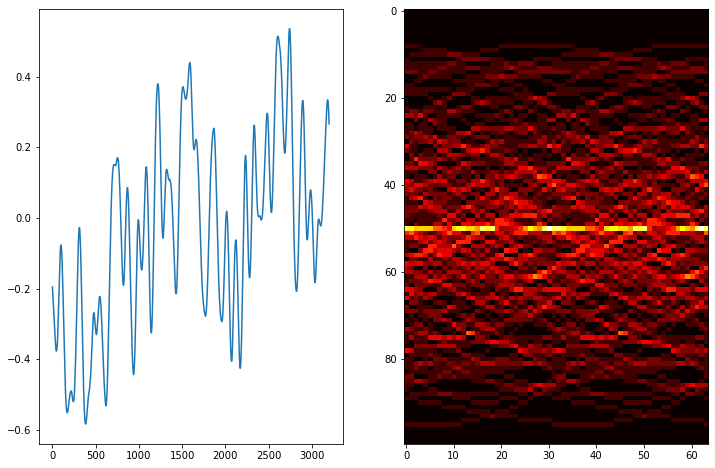

In [8]:
sig2 = channel_model(sig)  # Apply custom channel model to the Tx output signal.

rx_cfg        = myPyBERT._rx_cfg  # Grab the 'AMIParamConfigurator' instance for this model.                                     
rx_param_dict = rx_cfg.input_ami_params                                                                               
rx_model_init = AMIModelInitializer(rx_param_dict)                                                                    
rx_model_init.sample_interval  = Ts  # Must be set, before 'channel_response'!                                         
rx_model_init.channel_response = myPyBERT.tx_out_h / Ts                                                                        
rx_model_init.bit_time         = ui                                                                                           
rx_model = AMIModel(myPyBERT.rx_dll_file)                                                                                 
rx_model.initialize(rx_model_init)                                                                                    

print("Rx IBIS-AMI model initialization results:")
print(f"Input parameters: {rx_model.ami_params_in}")
print(f"Message: {rx_model.msg}")
print(f"Output parameters: {rx_model.ami_params_out}")
rx_out, clock_times = rx_model.getWave(sig2, len(sig2))
plotsig(rx_out)